<a href="https://colab.research.google.com/github/frederikvanduuren/Mentor/blob/master/Session_7_eNAS_ReLu%2BBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, SeparableConv2D, DepthwiseConv2D, Cropping2D, UpSampling2D
from keras.layers import Activation, Flatten, Dense, Dropout, concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.utils import plot_model

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
! pip install wandb
! wandb login 02d32f311f4a871d8e69b91f9ab2532052b9b622


     |████████████████████████████████| 1.3MB 4.9MB/s 
     |████████████████████████████████| 460kB 25.0MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 256kB 45.3MB/s 
     |████████████████████████████████| 184kB 41.4MB/s 
  Created wheel for gql: filename=gql-0.1.0-cp36-none-any.whl size=5541 sha256=76886bd30f08ba1a9a91550f9ce7e11bb2156dfe08d423f7d13effa4944813e3
  Stored in directory: /root/.cache/pip/wheels/a7/8d/65/a3247f500d675d80a01e4d2f0ee44fe99f1faef575bc2a1664
  Created wheel for watchdog: filename=watchdog-0.9.0-cp36-none-any.whl size=73652 sha256=715bff95d4946d2abb8f1258b0c90e551feba23667993b9735203e323ede6d7f
  Stored in directory: /root/.cache/pip/wheels/61/1d/d0/04cfe495619be2095eb8d89a31c42adb4e42b76495bc8f784c
  Created wheel for shortuuid: filename=shor

In [4]:
import wandb
from wandb.keras import WandbCallback
#wandb.init(project="session-7-eNAS", sync_tensorboard=True)
wandb.init(project="session-7-enas")

W&B Run: https://app.wandb.ai/frederikvanduuren/session-7-enas/runs/wmzi5tfo

In [0]:
import os 

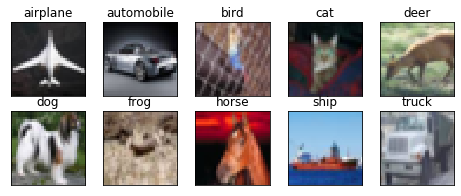

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Images must be Z-score (mean-std) normalized because that’s how we have implemented while training also. Z-score normalization is important because it results in similarly-ranged feature values and that the gradients don’t go out of control (need one global learning rate multiplier).

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# mean-std normalization
mean = np.mean(train_features,axis=(0,1,2,3))
std = np.std(train_features,axis=(0,1,2,3))
train_features = (train_features-mean)/(std+1e-7)
test_features = (test_features-mean)/(std+1e-7)

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [10]:
from keras import regularizers
from keras.layers import add


# Define the model
# input layer
input = Input(shape=(32,32,3))
numberofconvs = 48
# first feature extractor with 3x3 kernel
layer1 = SeparableConv2D(numberofconvs, (5, 5), border_mode='same', activation='relu', input_shape=(32, 32, 3), dilation_rate=1)(input)
layer1 = BatchNormalization()(layer1)
layer2 = Convolution2D(numberofconvs, (5, 5),dilation_rate=1, activation='relu', padding="same")(layer1)
layer2 = BatchNormalization()(layer2)
layer3 = Convolution2D(numberofconvs, (5, 5),dilation_rate=1, activation='relu', padding="same")(layer2)
layer3 = BatchNormalization()(layer3)
merge3 = concatenate([layer1, layer3], axis=-1)

layer4 = SeparableConv2D(numberofconvs, (5, 5),dilation_rate=1, activation='relu', padding="same")(merge3)
layer4 = BatchNormalization()(layer4)
merge4 = concatenate([layer4,layer1])

layer5 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same", data_format='channels_last')(merge4)
layer5 = Dropout(0.3)(layer5) # dropout 30%
layer6 = SeparableConv2D(numberofconvs, (3, 3),dilation_rate=1, activation='relu', padding="same", data_format='channels_last')(layer5)
layer6 = BatchNormalization()(layer6)
merge6 = concatenate([layer6,layer4])

layer7 = Convolution2D(numberofconvs, (5, 5),dilation_rate=1, activation='relu', padding="same")(merge6)
layer7 = BatchNormalization()(layer7)
merge7 = concatenate([layer7,layer6,layer4,layer1])

layer8 = SeparableConv2D(numberofconvs, (3, 3),dilation_rate=1, activation='relu', padding="same", data_format='channels_last')(merge7)
layer8 = BatchNormalization()(layer8)
merge8 = concatenate([layer8,layer7,layer3,layer6,layer1,layer4])

layer9= Convolution2D(numberofconvs, (5, 5),dilation_rate=1, activation='relu', padding="same")(merge8)
layer9 = BatchNormalization()(layer9)
merge9 = concatenate([layer9,layer8,layer6,layer4])

layer10 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same",data_format='channels_last')(merge9)
layer10 = Dropout(0.3)(layer10) # dropout 30%
merge10 = concatenate([layer10,layer7])

layer11= Convolution2D(numberofconvs, (5, 5),dilation_rate=1, activation='relu', padding="same")(merge10)
layer11 = BatchNormalization()(layer11)
merge11 = concatenate([layer11,layer8,layer2,layer4])

layer12 = SeparableConv2D(numberofconvs, (5, 5),dilation_rate=1, activation='relu', padding="same")(merge11)
layer12 = BatchNormalization()(layer12)
merge12 = concatenate([layer12,layer11,layer3,layer2,layer6])

layer13 = Convolution2D(numberofconvs, (3, 3),dilation_rate=1, activation='relu', padding="same")(merge12)
layer13 = BatchNormalization()(layer13)
merge13 = concatenate([layer13,layer3,layer8,layer12,layer4,layer6,layer1])

layer14 = SeparableConv2D(numberofconvs, (5, 5),dilation_rate=1, activation='relu', padding="same")(merge13)
layer14 = BatchNormalization()(layer14)
merge14 = concatenate([layer14,layer8,layer12,layer4])

flatten15 = Flatten()(merge14)
relu2 = Activation('relu')(flatten15)
output = Dense(10, activation='softmax')(relu2)

# prediction output
model = Model(inputs=input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#model.add(Activation('softmax'))
# Compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#rmspop = optimizers.RMSprop(lr=0.001, rho=0.9)
#model.compile(optimizer=rmspop, loss='categorical_crossentropy', metrics=['accuracy'])
#adamax = optimizers.Adamax()
#model.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])
#nadam = optimizers.Nadam()
#model.compile(optimizer=nadam, loss='categorical_crossentropy', metrics=['accuracy'])

#wandb.init(name="BN > RELU > MXP > DO")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(48, (5, 5), activation="relu", input_shape=(32, 32, 3..., dilation_rate=1, padding="same")`
  # Remove the CWD from sys.path while we load stuff.








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 48)   267         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 48)   192         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 48)   57648       batch_normalization_1[0][0]      
____________________________________________________________________________________________

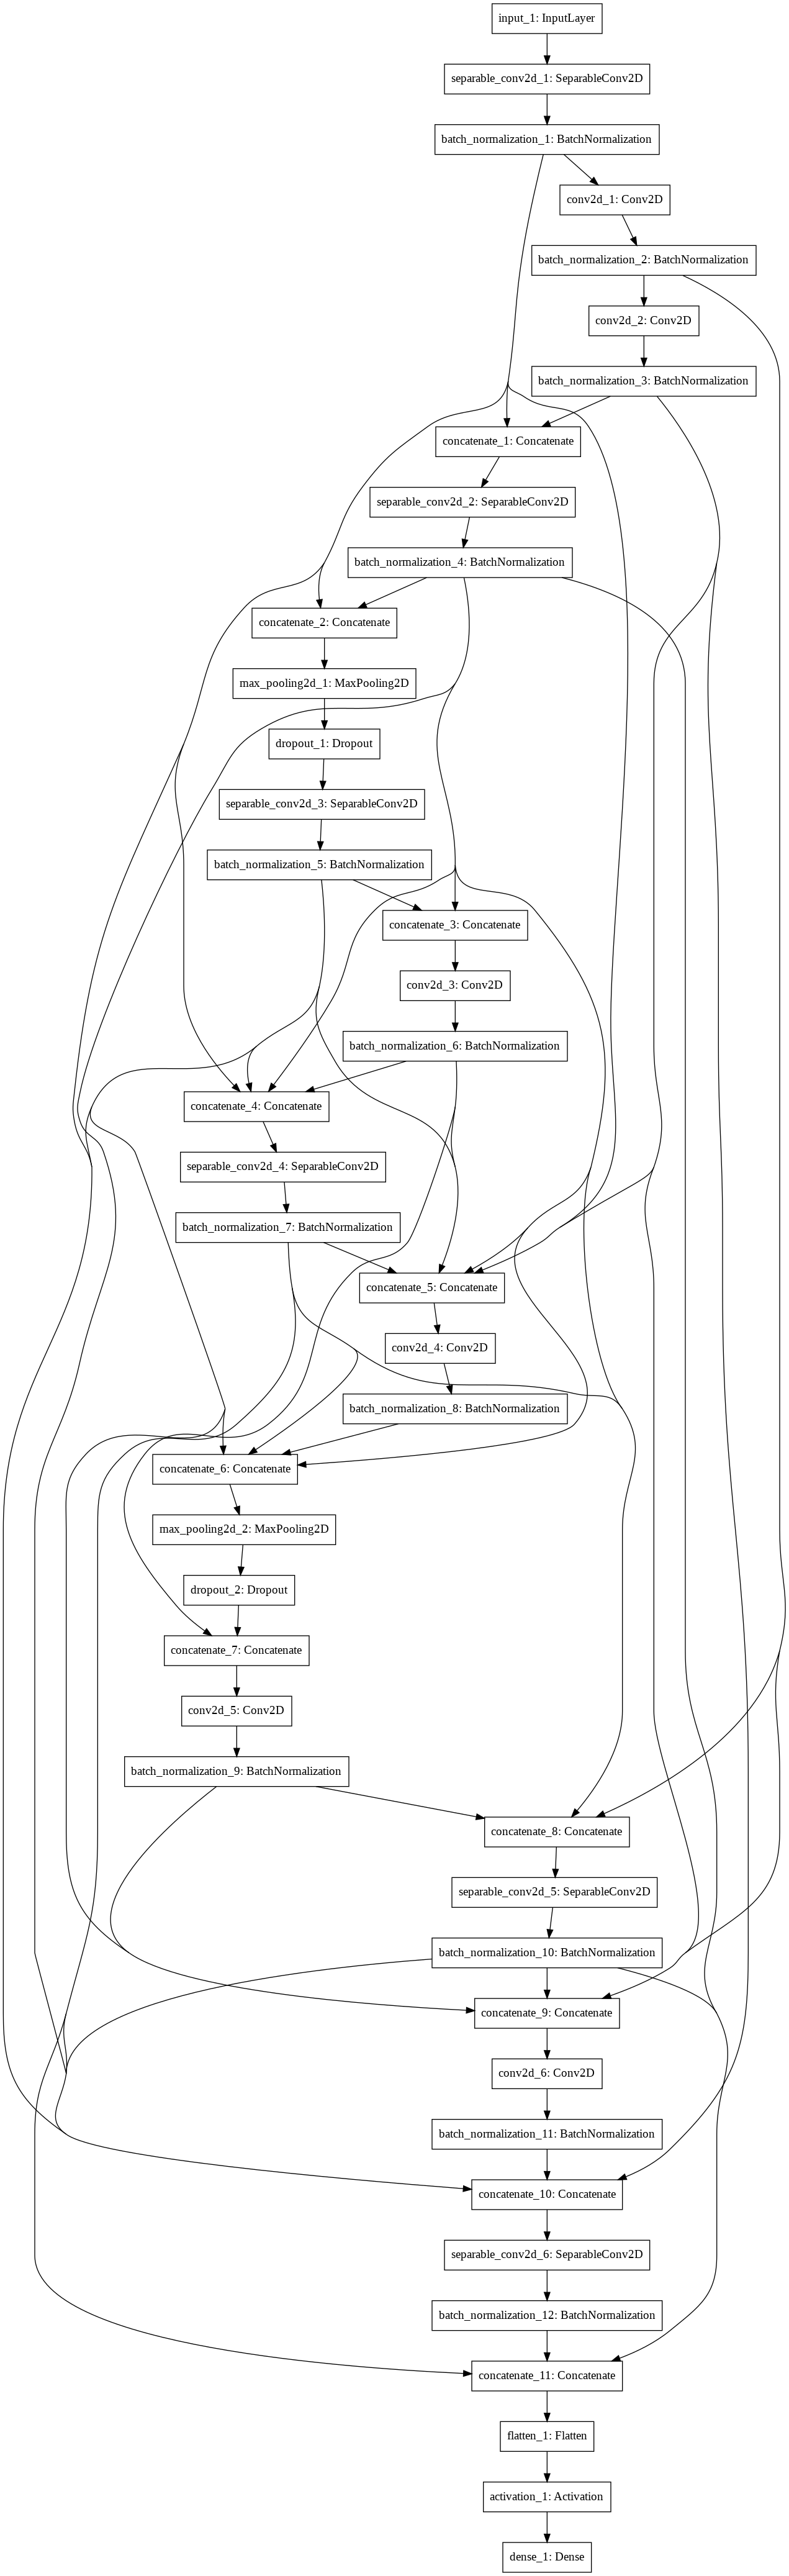

In [11]:
model.summary()
plot_model(model, to_file='recurrent_neural_network.png')

In keras, fit() is much similar to sklearn's fit method, where you pass array of features as x values and target as y values. You pass your whole dataset at once in fit method. Also, use it if you can load whole data into your memory (small dataset).

In fit_generator(), you don't pass the x and y directly, instead they come from a generator. As it is written in keras documentation, generator is used when you want to avoid duplicate data when using multiprocessing. This is for practical purpose, when you have large dataset.

A thing you should know about Keras if you plan to train a deep learning model on a large dataset:
https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import datetime

datagen = ImageDataGenerator(zoom_range=0.0, horizontal_flip=False)

#datagen = ImageDataGenerator(zca_whitening=True)
#datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

#from keras.callbacks import EarlyStopping
#callbacks = [EarlyStopping(monitor='val_acc', patience=2)]

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[WandbCallback()])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<wandb.ke..., steps_per_epoch=390, epochs=50)`




Epoch 1/50
 96/390 [======>.......................] - ETA: 3:38 - loss: 14.3919 - acc: 0.0991